In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from collections import Counter, defaultdict
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

In [2]:
snippet_pos = pickle.load(open('snippet_pos.p', 'rb'))
questions = pickle.load(open('questions.p', 'rb'))

In [3]:
full_feature_samples, semi_feature_samples, bin_feature_samples, acconly_baseline_samples, allpost_baseline_samples, random_samples = pickle.load(open('samples.added_feat.p', 'rb'))
folds = [1, 2, 3, 4, 5]
full_feature_samples = [x for x in full_feature_samples if x['fold_id'] in folds]
semi_feature_samples = [x for x in semi_feature_samples if x['fold_id'] in folds]
bin_feature_samples = [x for x in bin_feature_samples if x['fold_id'] in folds]

In [4]:
transfer_full_feature_samples, transfer_bin_feature_samples = pickle.load(open('samples.transfer.p', 'rb'))

In [5]:
print 'acconly: %d examples' % len(acconly_baseline_samples)
print 'all: %d examples' % len(allpost_baseline_samples)

acconly: 20 examples
all: 208 examples


In [6]:
# create_points = create_points_count
total_annotated = sum(map(lambda x: x['example']['label'], full_feature_samples))
print total_annotated

225


In [7]:
# baseline_mined = [len(baseline_samples)]
# baseline_pos = [sum(1 for pid, intent, code, is_annotated in baseline_samples if is_annotated)]
baseline_wins = sum([1 for e in acconly_baseline_samples if e['example']['label']])
print baseline_wins

12


In [8]:
def get_y_true_and_predictor_scores(samples, is_random=False, is_baseline=False):
    y_true = np.array(map(lambda x: 1 if x['example']['label'] else 0, samples))
    if is_random:
        predictor_scores = np.array(range(len(samples))[::-1], dtype='float32')
    elif is_baseline:
        predictor_scores = np.ones(len(samples))
    else:
        predictor_scores = np.array(map(lambda x: x['probability'], full_feature_samples))
    
    return y_true, predictor_scores

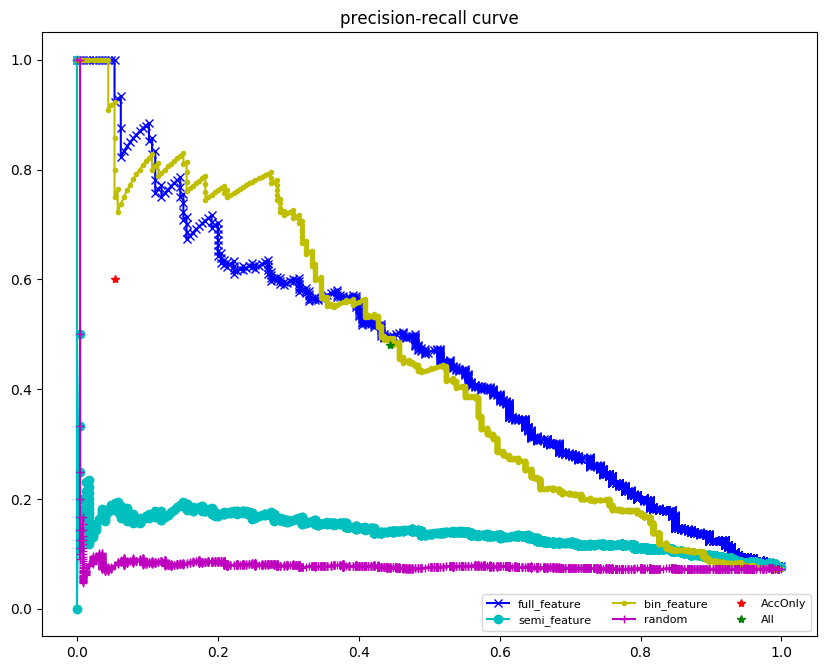

In [9]:
y_true_full_feat, scores_full_feat = get_y_true_and_predictor_scores(full_feature_samples)
y_true_semi_feat, scores_semi_feat = get_y_true_and_predictor_scores(semi_feature_samples)
y_true_bin_feat, scores_bin_feat = get_y_true_and_predictor_scores(bin_feature_samples)
y_true_rand, scores_rand = get_y_true_and_predictor_scores(random_samples, is_random=True)
y_true_acconly_baseline, scores_acconly_baseline = get_y_true_and_predictor_scores(acconly_baseline_samples, is_baseline=True)
y_true_allpost_baseline, scores_allpost_baseline = get_y_true_and_predictor_scores(allpost_baseline_samples, is_baseline=True)

precision_full_feat, recall_full_feat, _ = precision_recall_curve(y_true_full_feat, scores_full_feat)
precision_semi_feat, recall_semi_feat, _ = precision_recall_curve(y_true_semi_feat, scores_semi_feat)
precision_bin_feat, recall_bin_feat, _ = precision_recall_curve(y_true_bin_feat, scores_bin_feat)
precision_rand, recall_rand, _ = precision_recall_curve(y_true_rand, scores_rand)

precision_acconly_baseline = [sum(y_true_acconly_baseline) / float(len(y_true_acconly_baseline))]
recall_acconly_baseline = [sum(y_true_acconly_baseline) / float(sum(y_true_full_feat))]

precision_allpost_baseline = [sum(y_true_allpost_baseline) / float(len(y_true_allpost_baseline))]
recall_allpost_baseline = [sum(y_true_allpost_baseline) / float(sum(y_true_full_feat))]

plt.figure(figsize=(10, 8))
ax = plt.subplot()
colors = ['b', 'c', 'y', 'm', 'r', 'g']

pr_full_feat, = plt.plot(recall_full_feat, precision_full_feat, 'x-', color=colors[0])
pr_semi_feat, = plt.plot(recall_semi_feat, precision_semi_feat, 'o-', color=colors[1])
pr_bin_feat, = plt.plot(recall_bin_feat, precision_bin_feat, '.-', color=colors[2])
pr_rand, = plt.plot(recall_rand, precision_rand, '+-', color=colors[3])
pr_acconly_baseline, = plt.plot(recall_acconly_baseline, precision_acconly_baseline, '*', color=colors[4])
pr_allpost_baseline, = plt.plot(recall_allpost_baseline, precision_allpost_baseline, '*', color=colors[5])

plt.legend((pr_full_feat, pr_semi_feat, pr_bin_feat, pr_rand, pr_acconly_baseline, pr_allpost_baseline),
          ('full_feature', 'semi_feature', 'bin_feature', 'random', 'AccOnly', 'All'),
          scatterpoints=1,
          loc='lower right',
          ncol=3,
          fontsize=8)
#ax.set_xlim([0, 100])
#ax.set_ylim([0, 100])
plt.title('precision-recall curve')
plt.show()

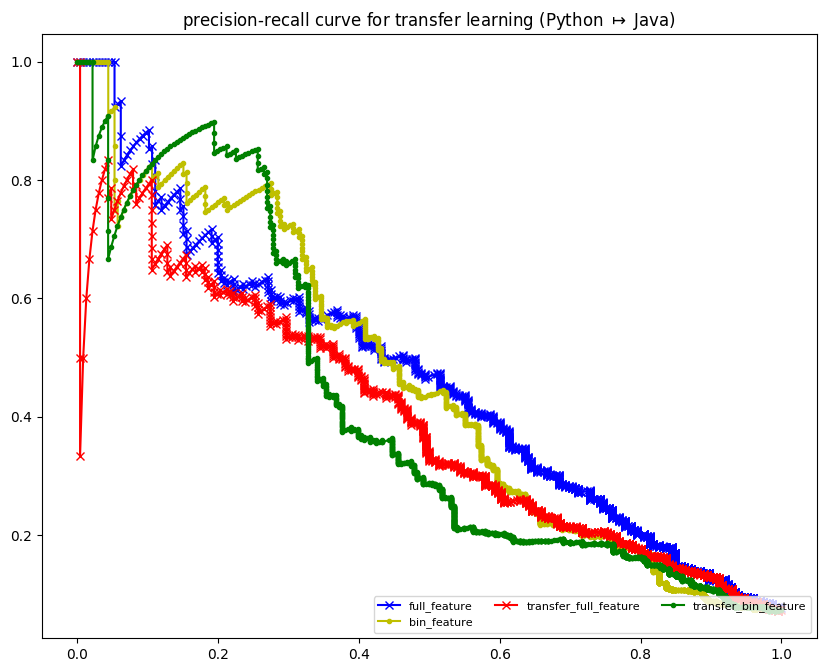

In [10]:
y_true_transfer_full_feat, scores_transfer_full_feat = get_y_true_and_predictor_scores(transfer_full_feature_samples)
y_true_transfer_bin_feat, scores_transfer_bin_feat = get_y_true_and_predictor_scores(transfer_bin_feature_samples)

precision_transfer_full_feat, recall_transfer_full_feat, _ = precision_recall_curve(y_true_transfer_full_feat, scores_transfer_full_feat)
precision_transfer_bin_feat, recall_transfer_bin_feat, _ = precision_recall_curve(y_true_transfer_bin_feat, scores_transfer_bin_feat)

plt.figure(figsize=(10, 8))
ax = plt.subplot()
colors = ['b', 'c', 'y', 'm', 'r', 'g']

pr_full_feat, = plt.plot(recall_full_feat, precision_full_feat, 'x-', color=colors[0])
pr_bin_feat, = plt.plot(recall_bin_feat, precision_bin_feat, '.-', color=colors[2])
pr_transfer_full_feat, = plt.plot(recall_transfer_full_feat, precision_transfer_full_feat, 'x-', color=colors[4])
pr_transfer_bin_feat,  = plt.plot(recall_transfer_bin_feat, precision_transfer_bin_feat, '.-', color=colors[5])

plt.legend((pr_full_feat, pr_bin_feat, pr_transfer_full_feat, pr_transfer_bin_feat),
          ('full_feature', 'bin_feature', 'transfer_full_feature', 'transfer_bin_feature'),
          scatterpoints=1,
          loc='lower right',
          ncol=3,
          fontsize=8)
#ax.set_xlim([0, 100])
#ax.set_ylim([0, 100])
plt.title('precision-recall curve for transfer learning (Python $\mapsto$ Java)')
plt.show()

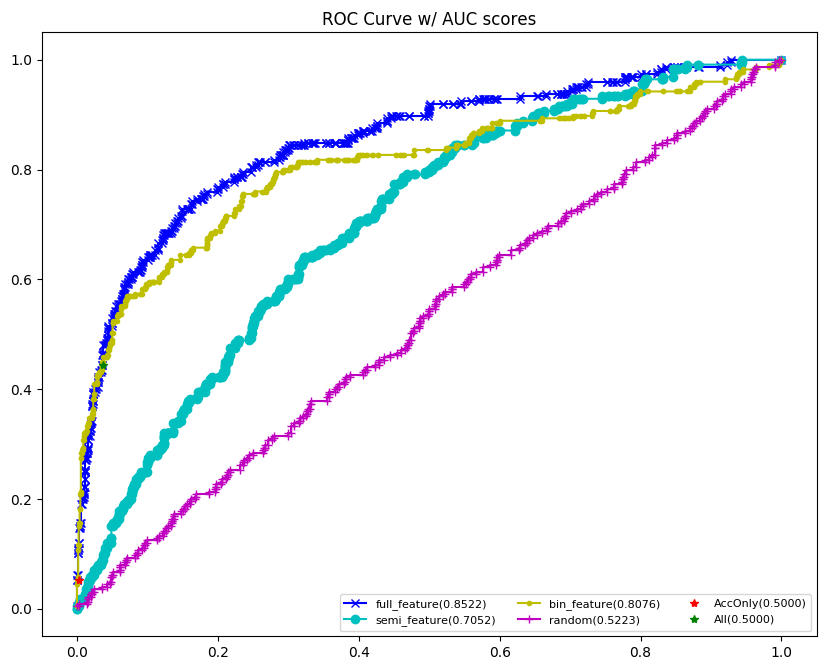

In [11]:
# precision, recall, thresholds = precision_recall_curve(y_true, probas_pred, pos_label=1)
# print precision[::-1][:10], full_feature_y[:10]
# print recall[::-1][:10], full_feature_x[:10]

# plt.figure(figsize=(10, 10))
# plt.plot(recall, precision, 'x-',)
# plt.show()

y_true_full_feat, scores_full_feat = get_y_true_and_predictor_scores(full_feature_samples)
fpr_full_feat, tpr_full_feat, thresholds_full_feat = roc_curve(y_true_full_feat, scores_full_feat, pos_label=1)
roc_auc_full_feat = roc_auc_score(y_true_full_feat, scores_full_feat)

y_true_semi_feat, scores_semi_feat = get_y_true_and_predictor_scores(semi_feature_samples)
fpr_semi_feat, tpr_semi_feat, thresholds_semi_feat = roc_curve(y_true_semi_feat, scores_semi_feat, pos_label=1)
roc_auc_semi_feat = roc_auc_score(y_true_semi_feat, scores_semi_feat)

y_true_bin_feat, scores_bin_feat = get_y_true_and_predictor_scores(bin_feature_samples)
fpr_bin_feat, tpr_bin_feat, thresholds_bin_feat = roc_curve(y_true_bin_feat, scores_bin_feat, pos_label=1)
roc_auc_bin_feat = roc_auc_score(y_true_bin_feat, scores_bin_feat)

y_true_rand, scores_rand = get_y_true_and_predictor_scores(random_samples, is_random=True)
fpr_rand, tpr_rand, thresholds_rand = roc_curve(y_true_rand, scores_rand, pos_label=1)
roc_auc_rand = roc_auc_score(y_true_rand, scores_rand)

y_true_baseline, scores_baseline = get_y_true_and_predictor_scores(acconly_baseline_samples, is_baseline=True)
fpr_baseline, tpr_baseline, thresholds_baseline = roc_curve(y_true_baseline, scores_baseline, pos_label=1)
roc_auc_baseline = roc_auc_score(y_true_baseline, scores_baseline)
tpr_baseline = [sum(y_true_baseline) / float(sum(y_true_full_feat))]
fpr_baseline = [(len(y_true_baseline) - sum(y_true_baseline)) / float(len(y_true_full_feat) - sum(y_true_full_feat))]

y_true_allpost_baseline, scores_allpost_baseline = get_y_true_and_predictor_scores(allpost_baseline_samples, is_baseline=True)
fpr_allpost_baseline, tpr_allpost_baseline, thresholds_allpost_baseline = roc_curve(y_true_baseline, scores_baseline, pos_label=1)
roc_auc_allpost_baseline = roc_auc_score(y_true_allpost_baseline, scores_allpost_baseline)
tpr_allpost_baseline = [sum(y_true_allpost_baseline) / float(sum(y_true_full_feat))]
fpr_allpost_baseline = [(len(y_true_allpost_baseline) - sum(y_true_allpost_baseline)) / float(len(y_true_full_feat) - sum(y_true_full_feat))]

plt.figure(figsize=(10, 8))

full_feature, = plt.plot(fpr_full_feat, tpr_full_feat, 'x-', color=colors[0])
semi_feature, = plt.plot(fpr_semi_feat, tpr_semi_feat, 'o-', color=colors[1])
bin_feature,  = plt.plot(fpr_bin_feat, tpr_bin_feat, '.-', color=colors[2])
random_selection,  = plt.plot(fpr_rand, tpr_rand, '+-', color=colors[3])
baseline_model,  = plt.plot(fpr_baseline, tpr_baseline, '*', color=colors[4])
allpost_baseline_model,  = plt.plot(fpr_allpost_baseline, tpr_allpost_baseline, '*', color=colors[5])

plt.legend((full_feature, semi_feature, bin_feature, random_selection, baseline_model, allpost_baseline_model),
          ('full_feature(%.4f)' % roc_auc_full_feat, 
           'semi_feature(%.4f)' % roc_auc_semi_feat, 
           'bin_feature(%.4f)' % roc_auc_bin_feat,
           'random(%.4f)' % roc_auc_rand,
           'AccOnly(%.4f)' % roc_auc_baseline,
           'All(%.4f)' % roc_auc_allpost_baseline),
          scatterpoints=1,
          loc='lower right',
          ncol=3,
          fontsize=8)

plt.title('ROC Curve w/ AUC scores')

plt.show()

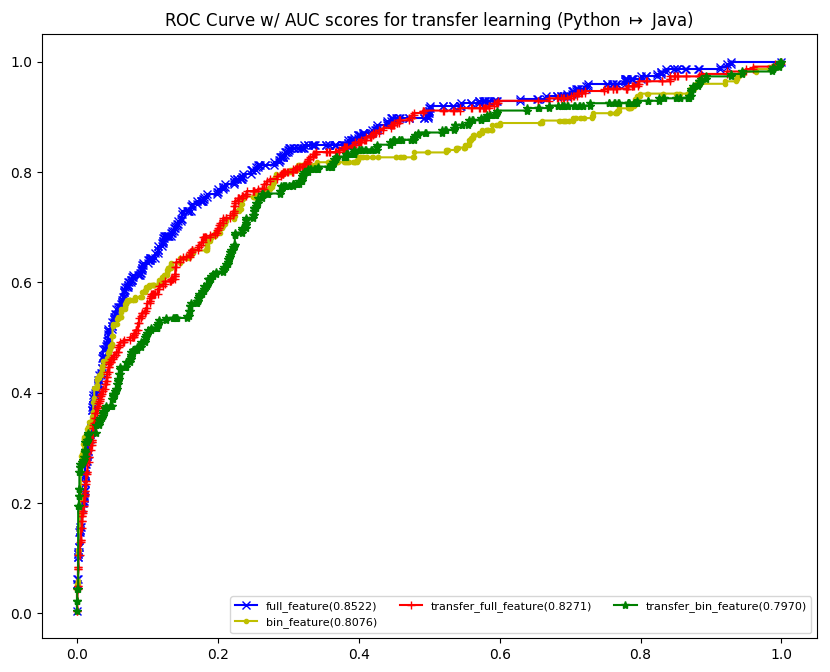

In [12]:
y_true_transfer_full_feat, scores_transfer_full_feat = get_y_true_and_predictor_scores(transfer_full_feature_samples)
fpr_transfer_full_feat, tpr_transfer_full_feat, thresholds_transfer_full_feat = roc_curve(y_true_transfer_full_feat, scores_transfer_full_feat, pos_label=1)
roc_auc_transfer_full_feat = roc_auc_score(y_true_transfer_full_feat, scores_transfer_full_feat)

y_true_transfer_bin_feat, scores_transfer_bin_feat = get_y_true_and_predictor_scores(transfer_bin_feature_samples)
fpr_transfer_bin_feat, tpr_transfer_bin_feat, thresholds_transfer_bin_feat = roc_curve(y_true_transfer_bin_feat, scores_transfer_bin_feat, pos_label=1)
roc_auc_transfer_bin_feat = roc_auc_score(y_true_transfer_bin_feat, scores_transfer_bin_feat)

plt.figure(figsize=(10, 8))

full_feature, = plt.plot(fpr_full_feat, tpr_full_feat, 'x-', color=colors[0])
bin_feature,  = plt.plot(fpr_bin_feat, tpr_bin_feat, '.-', color=colors[2])
transfer_full_feature,  = plt.plot(fpr_transfer_full_feat, tpr_transfer_full_feat, '+-', color=colors[4])
transfer_bin_feature,  = plt.plot(fpr_transfer_bin_feat, tpr_transfer_bin_feat, '*-', color=colors[5])

plt.legend((full_feature, bin_feature, transfer_full_feature, transfer_bin_feature),
          ('full_feature(%.4f)' % roc_auc_full_feat, 
           'bin_feature(%.4f)' % roc_auc_bin_feat,
           'transfer_full_feature(%.4f)' % roc_auc_transfer_full_feat,
           'transfer_bin_feature(%.4f)' % roc_auc_transfer_bin_feat),
          scatterpoints=1,
          loc='lower right',
          ncol=3,
          fontsize=8)

plt.title('ROC Curve w/ AUC scores for transfer learning (Python $\mapsto$ Java)')

plt.show()

In [13]:
with open('full_feat.top_predictions', 'w') as f:
    for i, sample in enumerate(full_feature_samples[:1000]):
        # if sample['example']['label'] == False:
        # print i, questions[sample['example']['question_id']]['title'], sample
        q_title = questions[sample['example']['question_id']]['title']
        f.write('%d\t%s\t%s\n\n' % (i, q_title, sample))

In [14]:
for i, sample in enumerate(bin_feature_samples[:30]):
    if sample['example']['label'] == False:
        print i, questions[sample['example']['question_id']]['title'], sample

10 how to get the one entry from hashmap without iterating {'fold_id': 3, 'predict_label': 1, 'example': {'code': 'System.out.println("Key: " + entry.getKey() + ", Value: " + entry.getValue());', 'features': {'ll_answer_post_zscore_code2nl': -1.4142135623730943, 'll_max': -21.503074645996094, 'll_snippet_zscore_nl2code': 0.0, 'start_with_assign && num_lines=1': False, 'll_min': -30.560922622680664, 'post_rank_0': 1, 'll_page_max_zscore': 1.2091079486845822, 'start_of_block': True, 'contains_import': False, 'll_page_zscore_code2nl': -1.4193337042110699, 'll_answer_post_zscore_nl2code': 1.4142135623730949, 'start_with_assign': False, 'num_lines': 1, 'only_snippet': False, 'end_of_line': True, 'accepted_ans': False, 'accepted_ans && only_snippet': False, 'll_nl2code': -21.503074645996094, 'll_page_zscore_nl2code': 1.2091079486845822, 'll_page_min_zscore': -1.4193337042110699, 'whole_block': True, 'num_lines=1': 1, 'end_of_block': True, 'accepted_ans && only_snippet && whole_block': False,